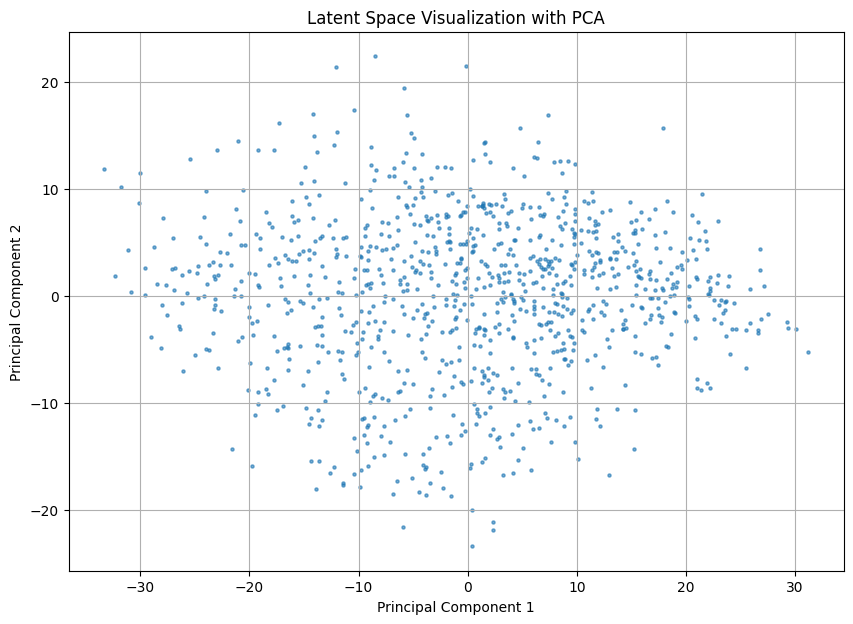

In [15]:
import torch
from torchvision import transforms
from data.image_dataset import ImageDataset
from torch.utils.data import DataLoader, Subset
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from model.vae.vae import VAE

# === Configuration ===
data_dir = "../datasets/VAE_val"
batch_size = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Image preprocessing ===
transform = transforms.Compose([
    transforms.ToTensor(),
    # For Stable Diffusion models, typically [-1, 1]
    transforms.Normalize([0.5], [0.5]),
])

dataset = ImageDataset(data_dir, transform=transform)
sub = Subset(dataset, indices=range(1000))
dataloader = DataLoader(sub, batch_size=batch_size, shuffle=False, num_workers=4)

# === Load your trained VAE model (Stable Diffusion VAE encoder) ===
# Replace this with your model loading code
vae = VAE().to(device)
vae.load_state_dict(torch.load("../runs/vae_base_nighttune/vae.safetensors"))

# === Extract latent vectors ===
latent_vectors = []

with torch.no_grad():
    for batch in dataloader:
        batch = batch.to(device)
        seed = torch.normal(0, 1, size=(batch.shape[0], 4, 32, 32)).to(device)
        latents = vae.encoder(batch, seed)[0]
        latents = latents.cpu().numpy()
        latent_vectors.append(latents)

latent_vectors = np.concatenate(latent_vectors, axis=0)
latent_vectors_flat = latent_vectors.reshape(latent_vectors.shape[0], -1)

# === Reduce dimensions with PCA ===
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_vectors_flat)

# === Plotting ===
plt.figure(figsize=(10, 7))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], s=5, alpha=0.6)
plt.title("Latent Space Visualization with PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()